In [24]:
import numpy as np
import pandas as pd
import pickle

import plotly.express as px
import plotly.graph_objects as go

import sys
import types

# Create a fake module to bypass the import error
sys.modules['pandas.core.indexes.numeric'] = types.ModuleType('numeric')

In [30]:
reference_path = "/cluster/project/cmdp/asallard/WP4/Route choice/reference_MZ.parquet"
calibration_path = "/cluster/project/cmdp/asallard/WP4/Route choice/choice-model/results_aurore/transit/calibration.p"

df_reference = pd.read_parquet(reference_path)

with open(calibration_path, "rb") as f:
    history = pickle.load(f)

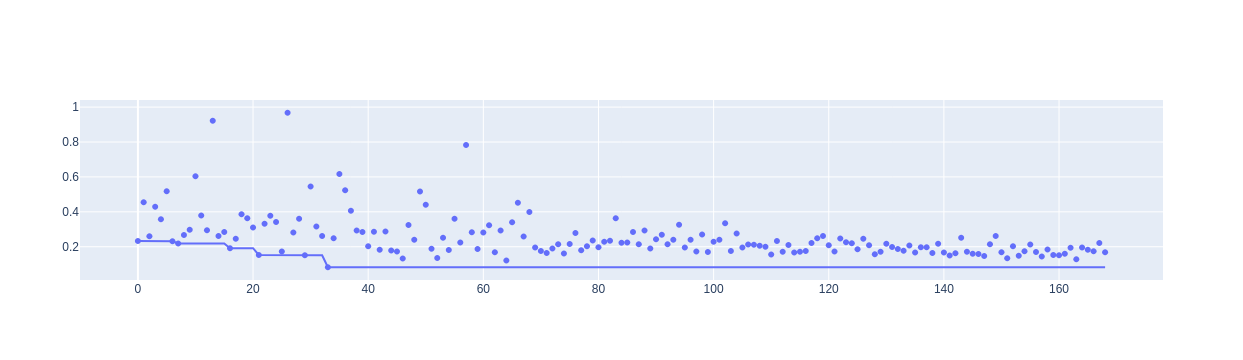

In [31]:
df_progress = pd.DataFrame.from_records([
    h["utilities"] for h in history
])

df_progress["objective"] = [h["objective"] for h in history]
df_progress["evaluation"] = np.arange(len(df_progress))

df_progress["best_objective"] = df_progress["objective"].cummin()

figure_scatter = px.scatter(df_progress, x = "evaluation", y = "objective")
figure_line = px.line(df_progress, x = "evaluation", y = "best_objective")
go.Figure(data = figure_scatter.data + figure_line.data)

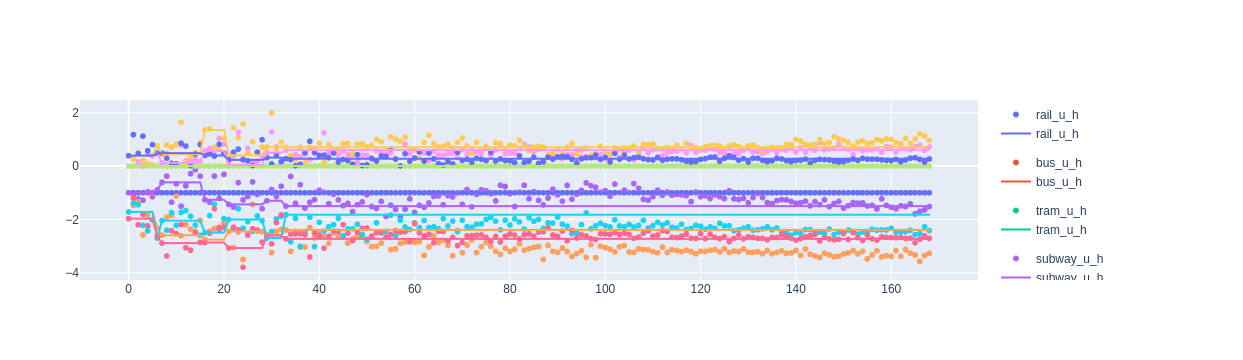

In [32]:
df_values = df_progress.drop(columns = ["objective", "best_objective"])

df_best = df_progress.copy()
is_best = df_best["objective"] == df_best["best_objective"]
df_best = df_best.drop(columns = ["objective", "best_objective"])
df_best = df_best.set_index("evaluation")
df_best.loc[~is_best, :] = np.nan
df_best = df_best.ffill().reset_index()

df_values = df_values.melt("evaluation")
df_best = df_best.melt("evaluation")

figure_scatter = px.scatter(df_values, x = "evaluation", y = "value", color = "variable")
figure_best = px.line(df_best, x = "evaluation", y = "value", color = "variable")
go.Figure(data = figure_scatter.data + figure_best.data)

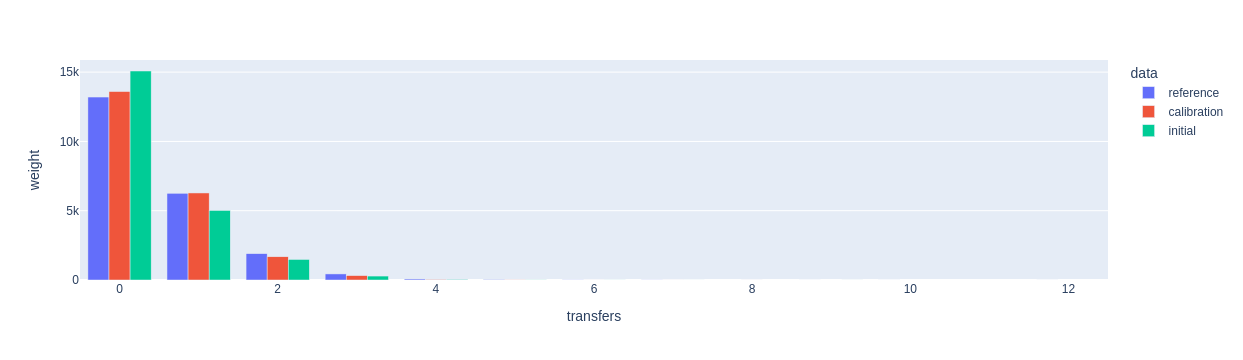

In [33]:
best_evaluation = history[df_progress["objective"].argmin()]
df_evaluation = best_evaluation["evaluation"]

df_reference["request_index"] = np.arange(len(df_reference))
df_evaluation = pd.merge(df_evaluation, df_reference[["request_index", "weight"]])

df_initial = pd.merge(history[0]["evaluation"], df_reference[["request_index", "weight"]])

df_reference_transfers = df_reference.groupby("transfers")["weight"].sum().reset_index()
df_reference_transfers["data"] = "reference"

df_evaluation_transfers = df_evaluation.groupby("transfers")["weight"].sum().reset_index()
df_evaluation_transfers["data"] = "calibration"

df_initial_transfers = df_initial.groupby("transfers")["weight"].sum().reset_index()
df_initial_transfers["data"] = "initial"

df_transfers = pd.concat([df_reference_transfers, df_evaluation_transfers, df_initial_transfers])
px.bar(df_transfers, x = "transfers", y = "weight", color = "data", barmode = "group")

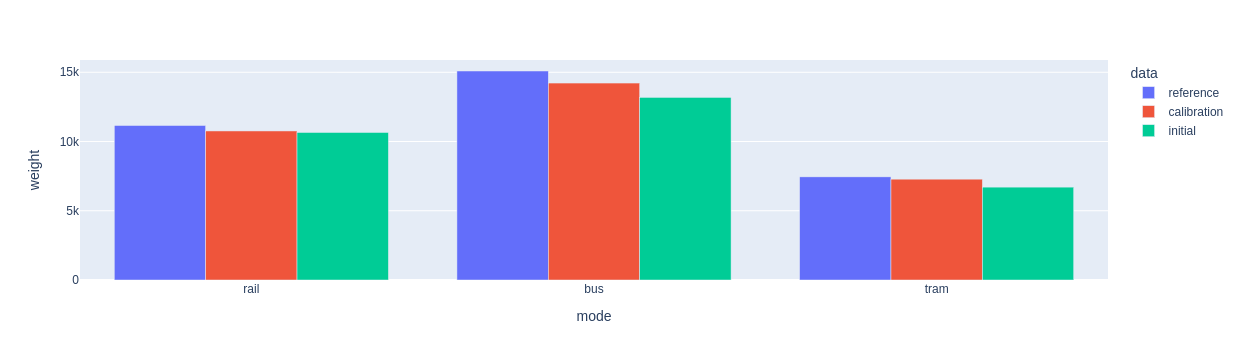

In [34]:

modes = ["rail", "bus", "tram"]
columns = ["legs_{}".format(m) for m in modes]
rename = { c: m for c, m in zip(columns, modes) }

df_reference_modes = df_reference[columns + ["weight"]]
df_reference_modes = df_reference_modes.rename(columns = rename)
for mode in modes: df_reference_modes[mode] *= df_reference_modes["weight"].values
df_reference_modes = df_reference_modes.drop(columns = "weight")
df_reference_modes = pd.DataFrame({ "mode": modes, "weight": df_reference_modes.sum(axis = 0) })
df_reference_modes["data"] = "reference"

df_evaluation_modes = df_evaluation[columns + ["weight"]]
df_evaluation_modes = df_evaluation_modes.rename(columns = rename)
for mode in modes: df_evaluation_modes[mode] *= df_evaluation_modes["weight"].values
df_evaluation_modes = df_evaluation_modes.drop(columns = "weight")
df_evaluation_modes = pd.DataFrame({ "mode": modes, "weight": df_evaluation_modes.sum(axis = 0) })
df_evaluation_modes["data"] = "calibration"

df_initial_modes = df_initial[columns + ["weight"]]
df_initial_modes = df_initial_modes.rename(columns = rename)
for mode in modes: df_initial_modes[mode] *= df_initial_modes["weight"].values
df_initial_modes = df_initial_modes.drop(columns = "weight")
df_initial_modes = pd.DataFrame({ "mode": modes, "weight": df_initial_modes.sum(axis = 0) })
df_initial_modes["data"] = "initial"

df_modes = pd.concat([df_reference_modes, df_evaluation_modes, df_initial_modes])
px.bar(df_modes, x = "mode", y = "weight", color = "data", barmode = "group")